In [131]:
# Modul Dasar
import numpy as np               # Operasi matematika dan array
import pandas as pd              # Struktur data tabular (DataFrame)
import matplotlib.pyplot as plt  # Visualisasi data
import seaborn as sns            # Visualisasi data tambahan

# Statistik dan Machine Learning
from scipy import stats          # Statistik
from sklearn import datasets     # Datasets untuk machine learning
from sklearn.model_selection import train_test_split  # Pembagian data train-test
from sklearn.preprocessing import StandardScaler     # Normalisasi data
from sklearn.linear_model import LinearRegression    # Regresi linear
from sklearn.tree import DecisionTreeClassifier      # Klasifikasi menggunakan Decision Tree
from sklearn.cluster import KMeans                    # KMeans clustering

# Evaluasi Model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report  # Evaluasi performa model

# Visualisasi Machine Learning
from sklearn.tree import plot_tree    # Visualisasi struktur Decision Tree
from sklearn.metrics import roc_curve, auc  # Kurva ROC dan AUC


from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

In [132]:
data = pd.read_csv("../data/external/ihsg 14-12-22 till 22-04-24.csv")
data.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-12-14,6810.355957,6854.098145,6774.131836,6801.749023,6801.749023,215430000
1,2022-12-15,6801.789063,6801.837891,6740.955078,6751.859863,6751.859863,145093400
2,2022-12-16,6751.859863,6812.192871,6693.765137,6812.192871,6812.192871,156126900


In [133]:
lengh_data = len(data)
split_ratio = 0.9
lengh_train = round(lengh_data * split_ratio)
lengh_validation = lengh_data -lengh_train

In [134]:
data = data.drop(["Volume"],axis=1)
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index("Date")

#hai widha

In [135]:
def time_series_to_supervised(data, n_in=1, n_out=1, dropnan=True, var_names=None):
    """
    Mengubah data time series menjadi data supervised learning.

    Argumen:
    data: DataFrame, dataset time series yang akan diubah.
    n_in: int, jumlah timestep mundur sebagai input (X).
    n_out: int, jumlah timestep maju sebagai output (y).
    dropnan: bool, apakah akan menghapus baris dengan nilai NaN.
    var_names: list of str, nama variabel untuk setiap kolom.

    Returns:
    DataFrame yang sudah diubah menjadi format supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = [], []
    
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        if var_names is None:
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        else:
            names += [(var_names[j] + '(t-%d)' % i) for j in range(n_vars)]
    
    # Output sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            if var_names is None:
                names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
            else:
                names += [(var_names[j] + '(t)') for j in range(n_vars)]
        else:
            if var_names is None:
                names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            else:
                names += [(var_names[j] + '(t+%d)' % i) for j in range(n_vars)]
    
    # Concatenate semua kolom
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # Hapus baris dengan nilai NaN
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg

# Contoh penggunaan:
# Misalkan 'data' adalah DataFrame yang berisi data time series
# dengan tiga fitur, dan kita ingin menggunakan 3 timestep mundur sebagai input
# dan 1 timestep maju sebagai output, dan nama variabel untuk setiap fitur adalah
# 'A', 'B', dan 'C'

var_names = data.columns
data_supervised = time_series_to_supervised(data, n_in=3, n_out=1, var_names=var_names)


In [136]:
train_data = data_supervised[:lengh_train]
validation_data = data_supervised[lengh_train:]

In [137]:
from sklearn.preprocessing import MinMaxScaler

# Inisialisasi MinMaxScaler
scaler = MinMaxScaler()

# Normalisasi data train
scaled_train_data = scaler.fit_transform(train_data)

# Konversi data yang telah dinormalisasi kembali ke dalam DataFrame
scaled_train_data = pd.DataFrame(scaled_train_data, columns=train_data.columns)



In [138]:
y_train_scaled = scaled_train_data[["Open(t)"]]  # Ambil kolom Open(t) sebagai target
X_train_scaled = scaled_train_data.drop(["Open(t)", "Close(t)", "High(t)", "Low(t)", "Adj Close(t)"], axis=1)

In [139]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Open(t-3)       287 non-null    float64
 1   High(t-3)       287 non-null    float64
 2   Low(t-3)        287 non-null    float64
 3   Close(t-3)      287 non-null    float64
 4   Adj Close(t-3)  287 non-null    float64
 5   Open(t-2)       287 non-null    float64
 6   High(t-2)       287 non-null    float64
 7   Low(t-2)        287 non-null    float64
 8   Close(t-2)      287 non-null    float64
 9   Adj Close(t-2)  287 non-null    float64
 10  Open(t-1)       287 non-null    float64
 11  High(t-1)       287 non-null    float64
 12  Low(t-1)        287 non-null    float64
 13  Close(t-1)      287 non-null    float64
 14  Adj Close(t-1)  287 non-null    float64
dtypes: float64(15)
memory usage: 33.8 KB


In [140]:
y_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Open(t)  287 non-null    float64
dtypes: float64(1)
memory usage: 2.4 KB


In [141]:
# Misalnya, Anda memiliki 3 langkah waktu dan 5 fitur
timesteps = 3
features = 5
X_train = []
for i in range(timesteps):
    X_train.append(X_train_scaled.iloc[:, i*features:(i+1)*features].values)

# Ubah list menjadi array numpy
X_train = np.array(X_train)
X_train = X_train.transpose(1, 0, 2)
# Bentuknya menjadi (jumlah_sampel, timestep, feature)
print(X_train.shape)

(287, 3, 5)


In [142]:
from keras.layers import LSTM

model_lstm = Sequential()
model_lstm.add(LSTM(128, activation='relu',return_sequences=True, input_shape=(X_train.shape[1], 5)))
model_lstm.add(LSTM(128,activation='relu', return_sequences=False))
model_lstm.add(Dense(128))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')
hist= model_lstm.fit(X_train, train_data['Open(t)'], epochs=200, batch_size=32)

Epoch 1/200
9/9 [==============================] - 5s 8ms/step - loss: 47763672.0000
Epoch 2/200
9/9 [==============================] - 0s 8ms/step - loss: 47754676.0000
Epoch 3/200
9/9 [==============================] - 0s 8ms/step - loss: 47714124.0000
Epoch 4/200
9/9 [==============================] - 0s 8ms/step - loss: 47459664.0000
Epoch 5/200
9/9 [==============================] - 0s 7ms/step - loss: 45688196.0000
Epoch 6/200
9/9 [==============================] - 0s 8ms/step - loss: 37855436.0000
Epoch 7/200
9/9 [==============================] - 0s 8ms/step - loss: 20406912.0000
Epoch 8/200
9/9 [==============================] - 0s 13ms/step - loss: 16678825.0000
Epoch 9/200
9/9 [==============================] - 0s 9ms/step - loss: 13075926.0000
Epoch 10/200
9/9 [==============================] - 0s 10ms/step - loss: 11804997.0000
Epoch 11/200
9/9 [==============================] - 0s 10ms/step - loss: 10215147.0000
Epoch 12/200
9/9 [==============================] - 0s 10ms/

In [143]:
y_pred = model_lstm.predict(X_train)

9/9 [==============================] - 1s 3ms/step


In [144]:
y_pred.shape

(287, 1)

In [145]:
y_pred.squeeze()

array([6812.264 , 6778.9116, 6806.5923, 6796.0474, 6788.7295, 6836.6587,
       6842.896 , 6829.16  , 6862.389 , 6915.4746, 6861.4136, 6865.3384,
       6873.7134, 6873.841 , 6884.1973, 6803.8823, 6659.394 , 6692.368 ,
       6693.1484, 6628.913 , 6613.015 , 6653.9927, 6672.3643, 6716.25  ,
       6779.065 , 6790.7173, 6841.1934, 6886.425 , 6875.1865, 6857.2603,
       6883.433 , 6909.434 , 6879.7593, 6863.309 , 6887.566 , 6910.3877,
       6925.872 , 6894.2915, 6946.3564, 6950.2114, 6915.3687, 6889.7026,
       6925.2134, 6954.1665, 6923.819 , 6913.82  , 6913.3677, 6906.606 ,
       6885.6353, 6828.011 , 6862.818 , 6878.3745, 6869.845 , 6867.162 ,
       6867.0405, 6872.352 , 6829.0913, 6823.925 , 6790.7197, 6795.479 ,
       6817.028 , 6781.6455, 6774.4224, 6647.721 , 6648.6343, 6598.961 ,
       6681.8687, 6642.6943, 6714.8745, 6769.438 , 6739.906 , 6788.4673,
       6843.9053, 6829.979 , 6830.736 , 6848.897 , 6842.355 , 6838.0005,
       6813.234 , 6792.94  , 6820.1484, 6816.9346, 

In [146]:
train_data['Open(t)']

Date
2022-12-19    6812.153809
2022-12-20    6779.698242
2022-12-21    6768.315918
2022-12-22    6820.702148
2022-12-23    6824.393066
                 ...     
2024-02-21    7345.791016
2024-02-22    7334.952148
2024-02-23    7326.526855
2024-02-26    7277.640137
2024-02-27    7263.987793
Name: Open(t), Length: 287, dtype: float64

In [147]:
mse = np.mean((y_pred.squeeze() - train_data['Open(t)'])**2)

# Menghitung Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print("MSE:", mse)
print("RMSE:", rmse)

MSE: 2631.3475082686587
RMSE: 51.2966617653494


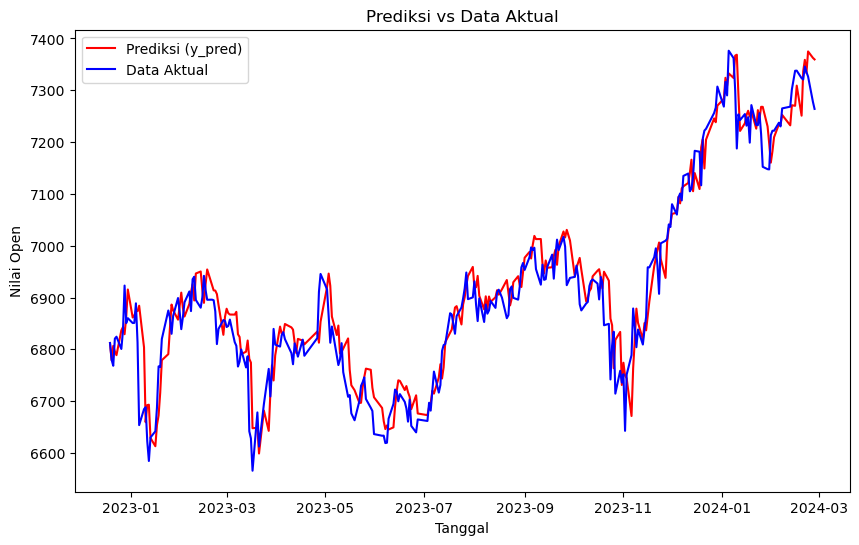

In [148]:
import matplotlib.pyplot as plt

# Plot hasil prediksi (y_pred) dan data aktual (train_data['Open(t)'])
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, y_pred.squeeze(), label='Prediksi (y_pred)', color='red')
plt.plot(train_data.index, train_data['Open(t)'], label='Data Aktual', color='blue')
plt.xlabel('Tanggal')
plt.ylabel('Nilai Open')
plt.title('Prediksi vs Data Aktual')
plt.legend()
plt.show()


In [149]:
scaled_val_data = scaler.fit_transform(validation_data)

# Konversi data yang telah dinormalisasi kembali ke dalam DataFrame
scaled_val_data = pd.DataFrame(scaled_val_data, columns=validation_data.columns)

In [150]:
scaled_val_data

,Open(t-3),High(t-3),Low(t-3),Close(t-3),Adj Close(t-3),Open(t-2),High(t-2),Low(t-2),Close(t-2),Adj Close(t-2),Open(t-1),High(t-1),Low(t-1),Close(t-1),Adj Close(t-1),Open(t),High(t),Low(t),Close(t),Adj Close(t)
0,0.671637,0.571037,0.600811,0.485230,0.485230,0.504029,0.401913,0.570649,0.505770,0.505770,0.457223,0.410283,0.579375,0.510708,0.510708,0.553520,0.598202,0.711209,0.697459,0.697459
1,0.504029,0.401913,0.570649,0.443250,0.443250,0.457223,0.393612,0.579375,0.510708,0.510708,0.553520,0.541021,0.684261,0.653925,0.653925,0.672584,0.627556,0.711445,0.661258,0.661258
2,0.457223,0.393612,0.579375,0.448813,0.448813,0.553520,0.528046,0.684261,0.653925,0.653925,0.672584,0.574553,0.684519,0.612515,0.612515,0.644686,0.606439,0.656786,0.649109,0.649109
3,0.553520,0.528046,0.684261,0.610146,0.610146,0.672584,0.562526,0.684519,0.612515,0.612515,0.644686,0.550430,0.624761,0.598618,0.598618,0.645255,0.597070,0.628363,0.547495,0.547495
4,0.672584,0.562526,0.684519,0.563498,0.563498,0.644686,0.537721,0.624761,0.598618,0.598618,0.645255,0.539728,0.593685,0.482382,0.482382,0.568807,0.523755,0.568100,0.462844,0.462844
5,0.644686,0.537721,0.624761,0.547843,0.547843,0.645255,0.526717,0.593685,0.482382,0.482382,0.568807,0.455979,0.527798,0.385551,0.385551,0.416414,0.605688,0.596736,0.700824,0.700824
6,0.645255,0.526717,0.593685,0.416904,0.416904,0.568807,0.440600,0.527798,0.385551,0.385551,0.416414,0.549573,0.559107,0.657775,0.657775,0.713482,0.784016,0.837824,0.828464,0.828464
7,0.568807,0.440600,0.527798,0.307823,0.307823,0.416414,0.536839,0.559107,0.657775,0.657775,0.713482,0.753279,0.822691,0.803781,0.803781,0.918153,0.878494,0.955438,0.851422,0.851422
8,0.416414,0.536839,0.559107,0.614484,0.614484,0.713482,0.746304,0.822691,0.803781,0.803781,0.918153,0.861202,0.951280,0.830043,0.830043,1.000000,0.958986,1.000000,0.965006,0.965006
9,0.713482,0.746304,0.822691,0.778960,0.778960,0.918153,0.857279,0.951280,0.830043,0.830043,1.000000,0.953149,1.000000,0.959970,0.959970,0.942625,1.000000,0.968063,1.000000,1.000000


In [151]:
y_val_scaled = scaled_val_data[["Open(t)"]]  # Ambil kolom Open(t) sebagai target
X_val_scaled = scaled_val_data.drop(["Open(t)", "Close(t)", "High(t)", "Low(t)", "Adj Close(t)"], axis=1)

In [152]:
timesteps = 3
features = 5
X_val = []
for i in range(timesteps):
    X_val.append(X_val_scaled.iloc[:, i*features:(i+1)*features].values)

# Ubah list menjadi array numpy
X_val = np.array(X_val)
X_val = X_val.transpose(1, 0, 2)
# Bentuknya menjadi (jumlah_sampel, timestep, feature)
print(X_val.shape)

(29, 3, 5)


In [153]:
y_val_pred = model_lstm.predict(X_val)

1/1 [==============================] - 0s 43ms/step


In [154]:
y_val_pred.squeeze()

array([6994.601 , 6982.784 , 6999.9927, 7097.9673, 7064.6245, 7028.625 ,
       6946.595 , 6907.2554, 7097.231 , 7238.5225, 7290.7666, 7359.898 ,
       7327.7256, 7084.892 , 7051.6904, 7131.9897, 7111.0996, 7151.142 ,
       7179.7217, 7217.515 , 7180.306 , 7028.5884, 6938.558 , 6708.2417,
       6794.9854, 6675.488 , 6866.5605, 6929.9663, 6581.984 ],
      dtype=float32)

In [155]:
validation_data['Open(t)']

Date
2024-02-28    7292.075195
2024-02-29    7326.803223
2024-03-01    7318.666016
2024-03-04    7318.832031
2024-03-05    7296.534180
2024-03-06    7252.084961
2024-03-07    7338.731934
2024-03-08    7398.429199
2024-03-13    7422.301758
2024-03-14    7405.566895
2024-03-15    7408.658203
2024-03-18    7338.076172
2024-03-19    7320.538086
2024-03-20    7303.929199
2024-03-21    7360.558105
2024-03-22    7327.514160
2024-03-25    7339.523926
2024-03-26    7337.661133
2024-03-27    7364.230957
2024-03-28    7289.158203
2024-04-01    7286.113770
2024-04-02    7199.124023
2024-04-03    7214.020020
2024-04-04    7170.719238
2024-04-05    7245.321777
2024-04-16    7130.627930
2024-04-17    7199.830078
2024-04-18    7151.737793
2024-04-19    7131.455078
Name: Open(t), dtype: float64

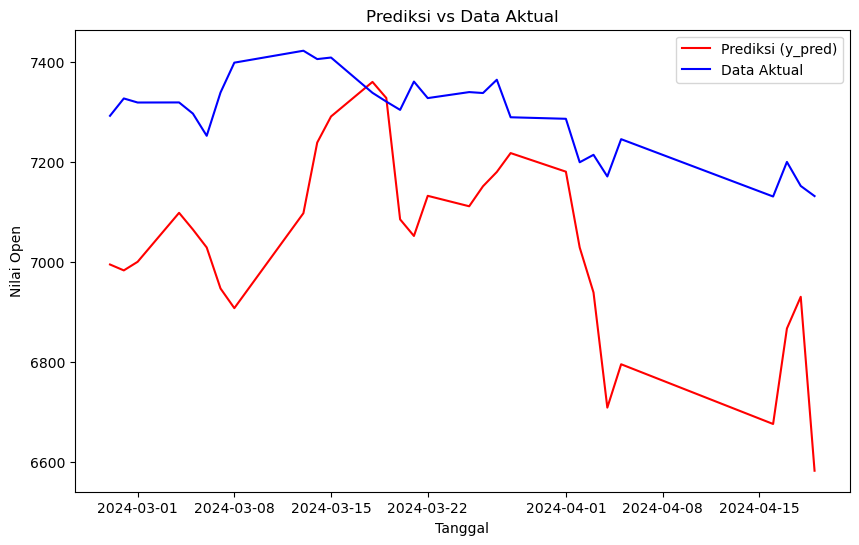

In [156]:
import matplotlib.pyplot as plt

# Plot hasil prediksi (y_pred) dan data aktual (train_data['Open(t)'])
plt.figure(figsize=(10, 6))
plt.plot(validation_data.index, y_val_pred.squeeze(), label='Prediksi (y_pred)', color='red')
plt.plot(validation_data.index, validation_data['Open(t)'], label='Data Aktual', color='blue')
plt.xlabel('Tanggal')
plt.ylabel('Nilai Open')
plt.title('Prediksi vs Data Aktual')
plt.legend()
plt.show()
